## Rhexis limbus detection
Exploration of algorithms to detect relevant anatomies on the plain rhexis eye model

### 1. Imports

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from helpers.limbus_detection import detect_circle
from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


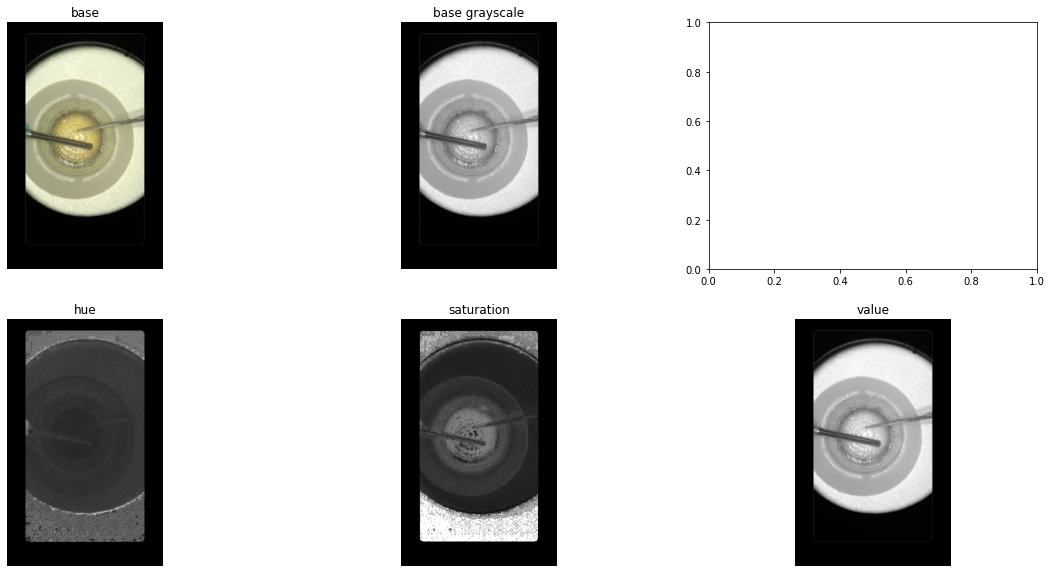

size: 312x496


In [31]:
scale = 0.33

base = cv2.imread('data/artificial/bioniko_rhexis_base4.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0, 0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:, :, 0]
base_saturation = base_hsv[:, :, 1]
base_value = base_hsv[:, :, 2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)
      ) = plt.subplots(2, 3, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### 2. Defining rhexis model constants

<table><tr>
    <td><img src="data/demonstrations/rhexis_full_diameter.png" width=200>pupil + iris diameter (full)</td>
    <td><img src="data/demonstrations/rhexis_pupil_diameter.png" width=200>pupil diameter</td>
</tr></table>

I did multiple manual measurements for each case to achieve higher accuracy.

In [32]:
measurements = [664, 664, 654, 663, 652]  # for diameter
RHEXIS_FULL_RADIUS = np.mean(measurements)/2

print('RHEXIS_FULL_RADIUS', RHEXIS_FULL_RADIUS)

RHEXIS_FULL_RADIUS 329.7


In [33]:
measurements = [431, 420, 430, 430, 429]  # for diameter
RHEXIS_PUPIL_RADIUS = np.mean(measurements)/2

print('RHEXIS_PUPIL_RADIUS', RHEXIS_PUPIL_RADIUS)

RHEXIS_PUPIL_RADIUS 214.0


In [34]:
PUPIL_TO_FULL_RATIO = RHEXIS_PUPIL_RADIUS / RHEXIS_FULL_RADIUS
print('pupil to full radia ratio', PUPIL_TO_FULL_RATIO)

pupil to full radia ratio 0.6490749165908402


### 3. Trying to segment pupil color
Tinkering with various thresholds in hsv color space to segment relevant anatomies. Keep in mind that OpenCV uses `[0, 179]` range for hue. For more info on this color space see [docs](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html).
I often use [this tool](http://mkweb.bcgsc.ca/color-summarizer/?analyze) to determine color distributions.

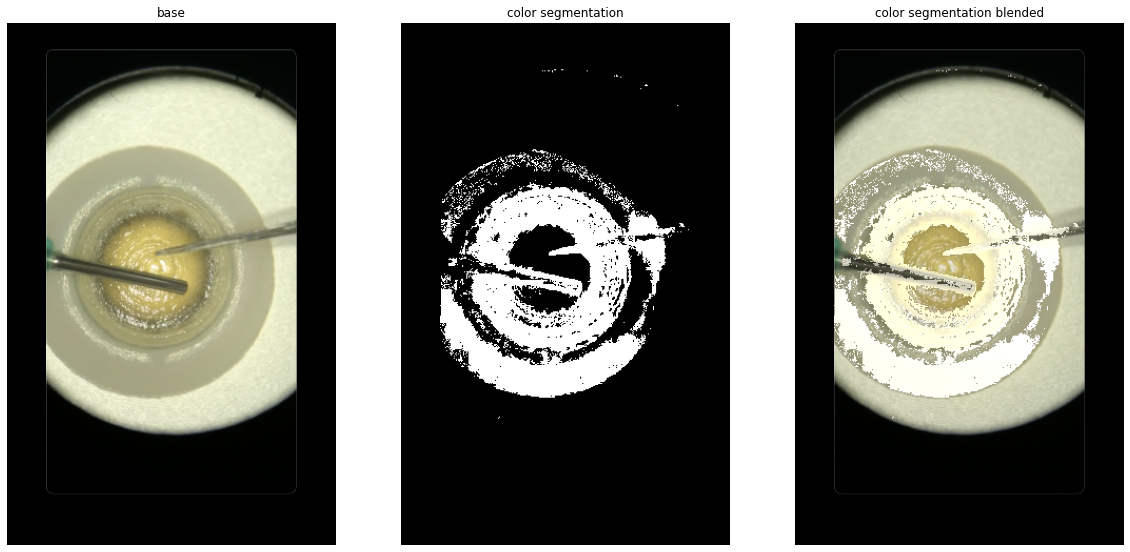

In [35]:
# old, prob too bright (default)
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])

# slightly better; would require correction
# pupil_color_lth = np.array([16, 97, 193])
# pupil_color_uth = np.array([29, 153, 255])

# for the more defined outer ring; bad for zoomed in cases
# pupil_color_lth = np.array([15, 38, 140])
# pupil_color_uth = np.array([30, 127, 230])

# oldest; from initial tests; segments the whole of the eye
# pupil_color_lth = np.array([10, 40, 40])
# pupil_color_uth = np.array([30, 180, 180])

base_pupil_thres = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)

base_blended = cv2.addWeighted(
    base_rgb,
    0.9,
    cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB),
    0.5,
    0.0
)

fig, plots = plt.subplots(1, 3, figsize=(20, 10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('color segmentation')
plots[1].imshow(base_pupil_thres, cmap='gray')
plots[1].axis('off')

plots[2].set_title('color segmentation blended')
plots[2].imshow(base_blended)
plots[2].axis('off')

plt.show()

### 4. HoughCircle detection on the thresholded iamge

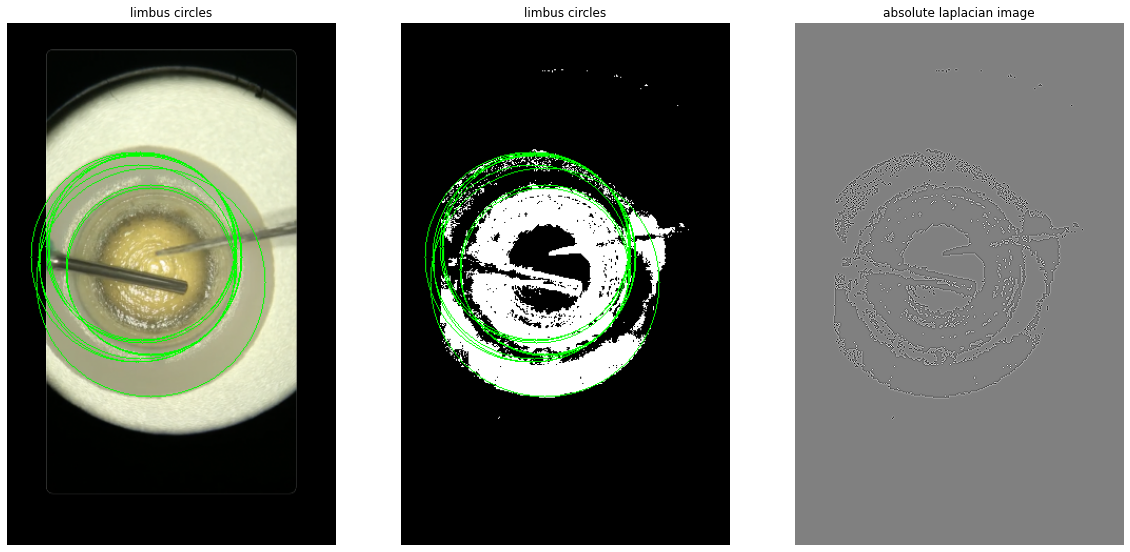

In [36]:
circles = detect_circle(
    base_pupil_thres,
    return_all=True
)

base_copy = base_rgb.copy()
base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB)

for circle in circles[:10]:
    cv2.circle(base_copy, tuple(np.round(circle[:2]).astype('int')),
               round(circle[2]), (0, 255, 0), thickness=1)
    cv2.circle(base_pupil_thres_copy, tuple(np.round(circle[:2]).astype('int')),
               round(circle[2]), (0, 255, 0), thickness=1)

fig, plots = plt.subplots(1, 3, figsize=(20, 10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('limbus circles')
plots[1].imshow(base_pupil_thres_copy)
plots[1].axis('off')

plots[2].set_title('absolute laplacian image')
plots[2].imshow(cv2.Laplacian(base_pupil_thres, cv2.CV_16S), cmap=plt.cm.gray)
plots[2].axis('off')

plt.show()

Displaying the best circle

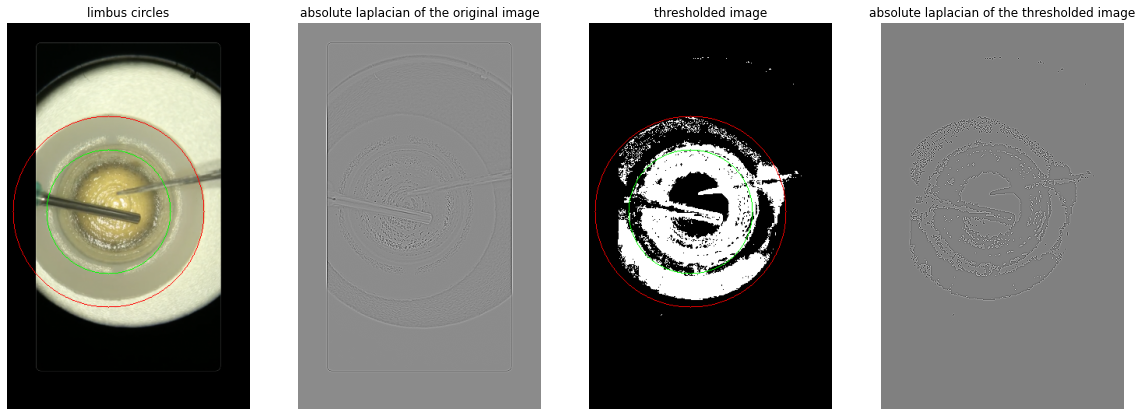

In [37]:
best_circle = detect_circle(
    base_pupil_thres,
    validation='inout',
    validation_mode='max'
)

base_copy = base_rgb.copy()
base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB)

cv2.circle(base_copy, tuple(np.round(best_circle[:2]).astype('int')),
           round(best_circle[2]), (0, 255, 0), thickness=1)
cv2.circle(base_pupil_thres_copy, tuple(np.round(best_circle[:2]).astype('int')),
           round(best_circle[2]), (0, 255, 0), thickness=1)

cv2.circle(base_copy, tuple(np.round(best_circle[:2]).astype('int')),
           round(best_circle[2]/PUPIL_TO_FULL_RATIO), (255, 0, 0), thickness=1)
cv2.circle(base_pupil_thres_copy, tuple(np.round(best_circle[:2]).astype('int')),
           round(best_circle[2]/PUPIL_TO_FULL_RATIO), (255, 0, 0), thickness=1)

fig, plots = plt.subplots(1, 4, figsize=(20, 10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('absolute laplacian of the original image')
plots[1].imshow(cv2.Laplacian(base_gray, cv2.CV_16S), cmap=plt.cm.gray)
plots[1].axis('off')

plots[2].set_title('thresholded image')
plots[2].imshow(base_pupil_thres_copy)
plots[2].axis('off')

plots[3].set_title('absolute laplacian of the thresholded image')
plots[3].imshow(cv2.Laplacian(base_pupil_thres, cv2.CV_16S), cmap=plt.cm.gray)
plots[3].axis('off')

plt.show()

I think this approach is a dead end, at least for this eye model. Tracking the edge of the whole model is feasible, but not realistic (as it is not visible when under the microscope).

### 5. Video demo without color thresholding, aiming to detect the outer edge of the whole eye

In [38]:
cap = cv2.VideoCapture('data/artificial/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(
    frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    circles = detect_circle(gray, view_mask=view_mask, return_all=True)
    if (circles is not None):
        best_circle = None
        for circle in circles:
            # similiarity of the detected circle and enclosure checks
            if any(np.abs(circle - view_circle) > np.array([20, 20, 20])):
                best_circle = circle
                break

        if best_circle is not None:
            cv2.circle(frame, tuple(np.round(best_circle[:2]).astype('int')),
                       round(best_circle[2]), (0, 255, 0), thickness=1)

    cv2.imshow('view mask', view_mask)
    cv2.imshow('detection', frame)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

### 6. Detection using contours

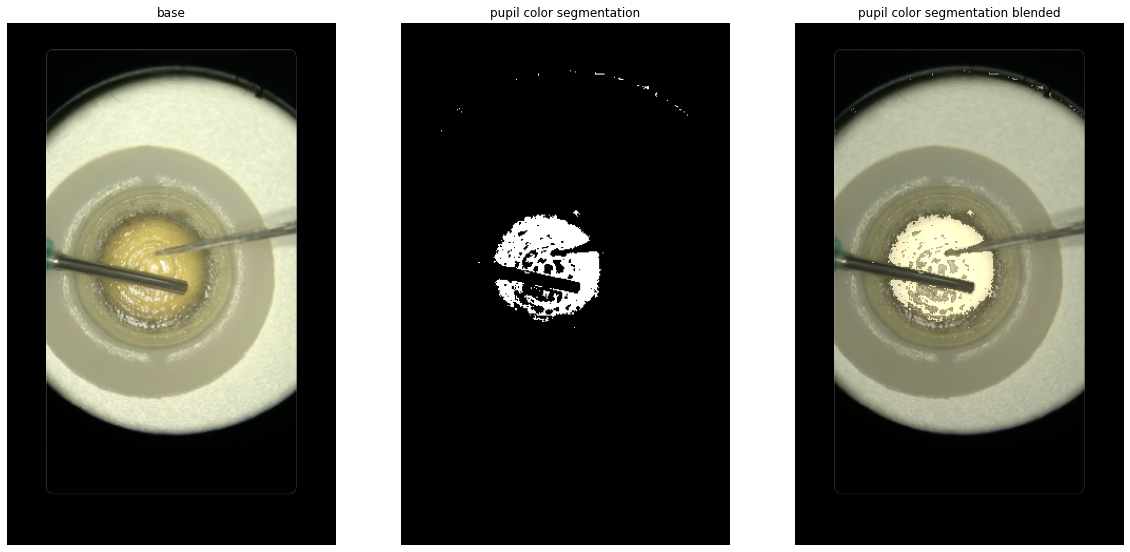

In [39]:
pupil_color_lth = np.array([10, 100, 20])
pupil_color_uth = np.array([35, 255, 255])

base_pupil_thres = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
base_blended = cv2.addWeighted(
    base_rgb,
    0.8,
    cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB),
    0.5,
    0.0
)

fig, plots = plt.subplots(1, 3, figsize=(20, 10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('pupil color segmentation')
plots[1].imshow(base_pupil_thres, cmap='gray')
plots[1].axis('off')

plots[2].set_title('pupil color segmentation blended')
plots[2].imshow(base_blended)
plots[2].axis('off')

plt.show()

Finding contours in the thresholded image. Unclear how to proceed from here as a high number of contours is found.

total of found contours: 115


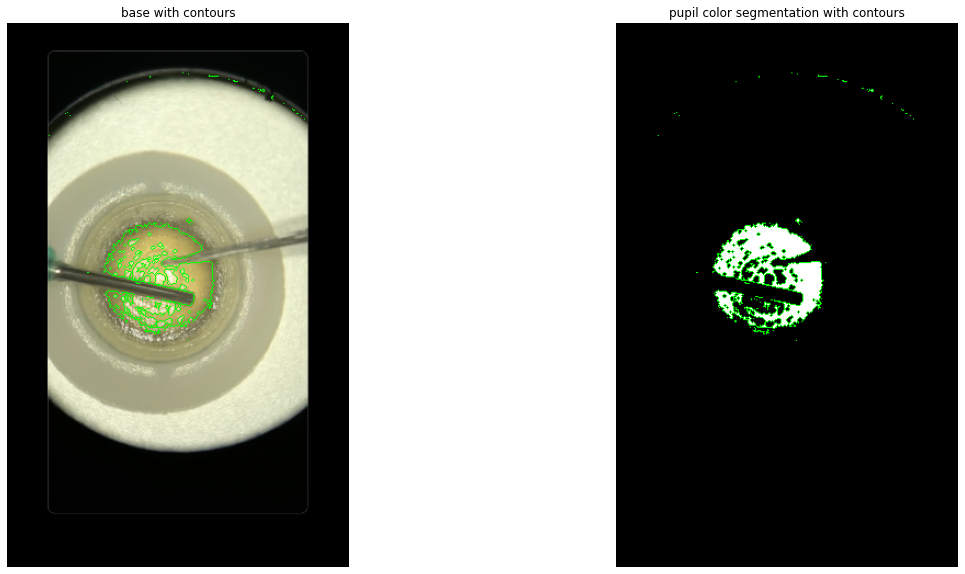

In [40]:
contours, _ = cv2.findContours(base_pupil_thres, 1, 2)

base_copy = base_rgb.copy()
cv2.drawContours(base_copy, contours, -1, (0, 255, 0))

base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2BGR)
cv2.drawContours(base_pupil_thres_copy, contours, -1, (0, 255, 0))

print('total of found contours: %d' % len(contours))

fig, plots = plt.subplots(1, 2, figsize=(20, 10))
plots[0].set_title('base with contours')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('pupil color segmentation with contours')
plots[1].imshow(base_pupil_thres_copy, cmap='gray')
plots[1].axis('off')

plt.show()

### 7. Morphological pre-processing
Color thresholding introduces salt and paper-like noise. We can mitigate this using the following methods. It is hard to determine the number of iterations and kernel sizes, though.

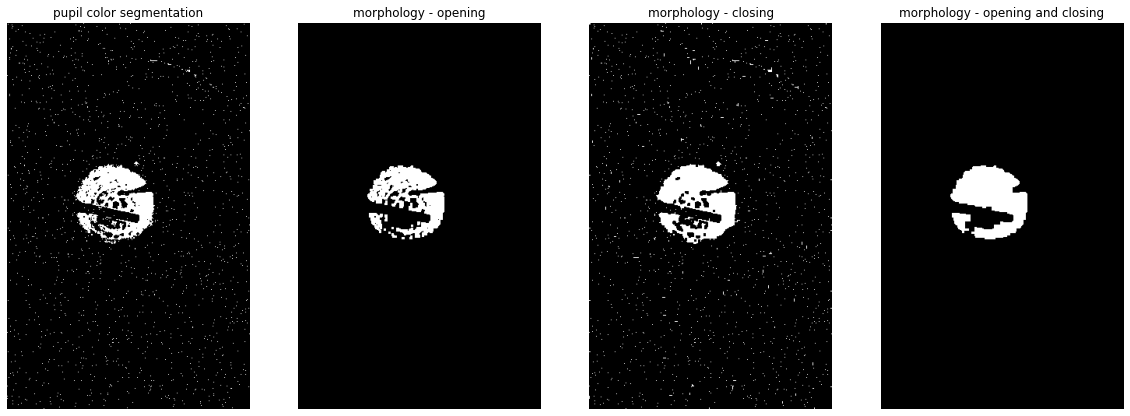

In [41]:
# could be automatically set based on moments
kernel = np.ones((3, 3), np.uint8)

base_pupil_thres_copy = base_pupil_thres.copy()
noise = np.random.rand(*base_pupil_thres_copy.shape)
base_pupil_thres_copy[noise > 0.99] = 255

opening = cv2.morphologyEx(base_pupil_thres_copy, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(base_pupil_thres_copy, cv2.MORPH_CLOSE, kernel)
opening_closing = cv2.morphologyEx(
    opening, cv2.MORPH_CLOSE, kernel, iterations=3)


fig, plots = plt.subplots(1, 4, figsize=(20, 10))
plots[0].set_title('pupil color segmentation')
plots[0].imshow(base_pupil_thres_copy, cmap='gray')
plots[0].axis('off')

plots[1].set_title('morphology - opening')
plots[1].imshow(opening, cmap='gray')
plots[1].axis('off')

plots[2].set_title('morphology - closing')
plots[2].imshow(closing, cmap='gray')
plots[2].axis('off')

plots[3].set_title('morphology - opening and closing')
plots[3].imshow(opening_closing, cmap='gray')
plots[3].axis('off')

plt.show()

### 8. Detection using image moments
Quite stable for determing the center when correctly thresholded. The radius is harder to determine as it is effected a lot by how successful the pre-processing is, occlusions, etc. We also have to provide scale coefficient which is not a straight-forward process.

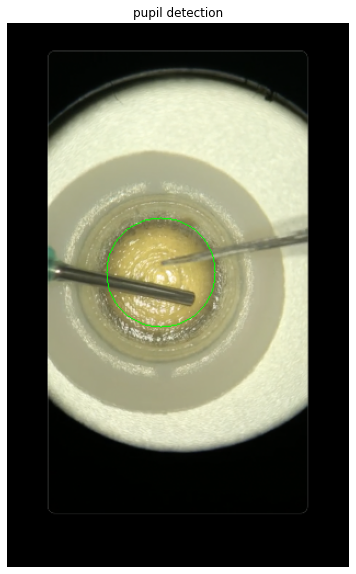

In [42]:
moments = cv2.moments(opening_closing, binaryImage=True)
center = (round(moments['m10']/moments['m00']),
          round(moments['m01']/moments['m00']))
std_est = np.sqrt(moments['mu20']/moments['m00']) + \
    np.sqrt(moments['mu02']/moments['m00'])
std_est /= 2
radius = round(2*std_est)

base_copy = base_rgb.copy()
cv2.circle(base_copy, center, radius, (0, 255, 0))

fig, plot = plt.subplots(1, 1, figsize=(10, 10))
plot.set_title('pupil detection')
plot.imshow(base_copy)
plot.axis('off')

plt.show()

Video demo

In [43]:
pupil_color_lth = np.array([15, 100, 50])
pupil_color_uth = np.array([30, 200, 255])

cap = cv2.VideoCapture('data/artificial/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(
    frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read()

    # performance measurement
    timer = cv2.getTickCount()

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    pupil_thres = cv2.inRange(hsv, pupil_color_lth, pupil_color_uth)
    blended = cv2.addWeighted(
        frame,
        0.8,
        cv2.cvtColor(pupil_thres, cv2.COLOR_GRAY2BGR),
        0.5,
        0.0
    )

    # morphological preprocessing
    pupil_thres = cv2.morphologyEx(
        pupil_thres, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    pupil_thres = cv2.morphologyEx(
        pupil_thres, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

    # finding the center of the detected structure
    moments = cv2.moments(pupil_thres, binaryImage=True)

    # performance measurement
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if moments['m00'] != 0:
        center = (round(moments['m10']/moments['m00']),
                  round(moments['m01']/moments['m00']))
        std_est = np.sqrt(moments['mu20']/moments['m00']) + \
            np.sqrt(moments['mu02']/moments['m00'])
        std_est /= 2
        radius = round(2*std_est)

        cv2.circle(frame, center, radius, (255, 0, 0))
        cv2.circle(frame, center, round(0.5*radius), (0, 255, 0))

        cv2.putText(frame, 'fps %d' % round(fps),
                    (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0, 255, 0), 1)
    else:
        cv2.putText(frame, 'moments could not be computed',
                    (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0, 255, 0), 2)

    cv2.imshow('blend', blended)
    cv2.imshow('thresholded', pupil_thres)
    cv2.imshow('original', frame)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)